In [130]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression

In [131]:
NUM_DAYS = 10000    
INTERVAL = '1d'     
symbol = 'SP'

[*********************100%***********************]  1 of 1 completed
4429
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2004-06-02  6.235  6.545  6.165  6.545      6.545  109200
2004-06-03  6.550  7.345  6.485  6.485      6.485  186400
2004-06-04  6.650  6.650  6.445  6.475      6.475  146200
2004-06-07  6.450  6.615  6.350  6.395      6.395  120800
2004-06-08  6.425  6.760  6.425  6.590      6.590  258200


<AxesSubplot:xlabel='Date'>

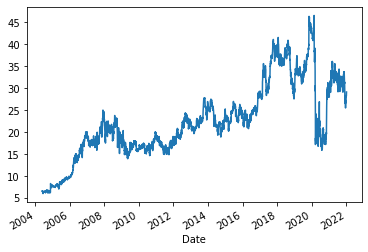

In [132]:
start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)

print(len(data))

print(data.head())

data["Close"].plot()

<AxesSubplot:xlabel='Date'>

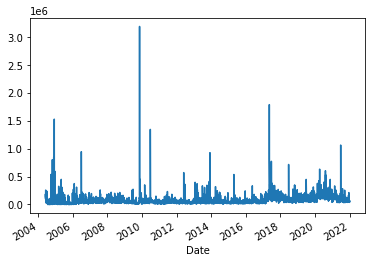

In [133]:
data["Volume"].plot()

<AxesSubplot:xlabel='Date'>

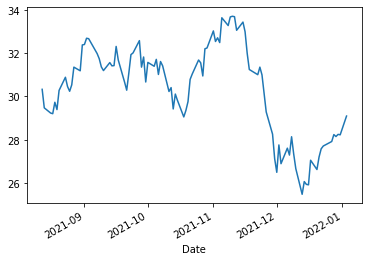

In [134]:
data.iloc[-100:]['Close'].plot()

                Open      High       Low     Close  Adj Close         Volume
Date                                                                        
2004-06-02  6.235000  6.545000  6.165000  6.545000   6.545000  109200.000000
2004-06-03  6.468334  7.137592  6.402037  6.500556   6.500556  166385.185185
2004-06-04  6.591706  6.806460  6.431214  6.483200   6.483200  152677.079796
2004-06-07  6.498194  6.680115  6.377621  6.424997   6.424997  131641.309907
2004-06-08  6.450367  6.732315  6.408580  6.532815   6.532815  214338.801197


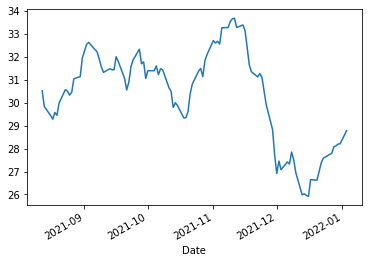

In [135]:
data = data.ewm(alpha=0.65).mean()
data = data.dropna()

data.iloc[-100:]['Close'].plot()

print(data.head())

In [136]:
live_pred_data = data.iloc[-100:-10]
live_pred_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-12,30.818910,31.199343,30.211138,30.521095,30.521095,49484.708644
2021-08-13,30.481618,31.102269,29.690398,29.837883,29.837883,54889.648025
2021-08-16,29.759067,30.002294,29.118139,29.442759,29.442759,93051.376809
2021-08-17,29.402173,29.597802,28.917848,29.284966,29.284966,134812.981883
2021-08-18,29.316261,30.034731,29.114246,29.574238,29.574238,119984.543659
...,...,...,...,...,...,...
2021-12-13,26.946981,27.111888,25.855749,25.982072,25.982072,76427.097185
2021-12-14,25.960944,26.610161,25.566012,26.026225,26.026225,165199.484015
2021-12-15,26.168331,26.395557,25.477604,25.957179,25.957179,124574.819405


In [137]:
def _produce_prediction(data, window):
    
    prediction = (data.shift(-window)['Close'] >= data['Close'])
    prediction = prediction.iloc[:-window]
    data['Pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['Close'])
data = data.dropna()
data.tail()
print(len(data))

print(data)


4414
                 Open       High        Low  Adj Close         Volume  Pred
Date                                                                       
2004-06-02   6.235000   6.545000   6.165000   6.545000  109200.000000   0.0
2004-06-03   6.468334   7.137592   6.402037   6.500556  166385.185185   0.0
2004-06-04   6.591706   6.806460   6.431214   6.483200  152677.079796   0.0
2004-06-07   6.498194   6.680115   6.377621   6.424997  131641.309907   0.0
2004-06-08   6.450367   6.732315   6.408580   6.532815  214338.801197   0.0
...               ...        ...        ...        ...            ...   ...
2021-12-06  27.417929  27.941977  26.782667  27.418628  102252.400236   1.0
2021-12-07  27.854775  28.239692  27.040934  27.328520   91233.340083   1.0
2021-12-08  27.643672  28.369892  27.222327  27.849482  140936.669029   1.0
2021-12-09  27.816785  28.252963  27.220814  27.511818   77602.834160   1.0
2021-12-10  27.591374  28.062536  26.739285  26.951636   72205.991956   1.0

[4414 

In [138]:
y = data['Pred']
features = [x for x in data.columns if x not in ['Pred']]
X = data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.33)

In [139]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test.values, rf_prediction)
print('Random Forest Classifier Accuracy = ' , rf_accuracy , "\n")
print(classification_report(y_test, rf_prediction))

Random Forest Classifier Accuracy =  0.6257606490872211 

              precision    recall  f1-score   support

         0.0       0.59      0.62      0.60      1365
         1.0       0.66      0.63      0.65      1593

    accuracy                           0.63      2958
   macro avg       0.62      0.63      0.62      2958
weighted avg       0.63      0.63      0.63      2958



In [140]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
knn_prediction = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test.values, knn_prediction)
print('KNeighbors Classifier Accuracy = ' , knn_accuracy , "\n")
print(classification_report(y_test, knn_prediction))
confusion_matrix_graph = confusion_matrix(y_test, knn_prediction)

KNeighbors Classifier Accuracy =  0.49898580121703856 

              precision    recall  f1-score   support

         0.0       0.45      0.42      0.43      1365
         1.0       0.53      0.57      0.55      1593

    accuracy                           0.50      2958
   macro avg       0.49      0.49      0.49      2958
weighted avg       0.50      0.50      0.50      2958



In [141]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_prediction = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test.values, lr_prediction)
print('Logistic Regression Classifier Accuracy = ' , lr_accuracy , "\n")
print(classification_report(y_test, lr_prediction))

Logistic Regression Classifier Accuracy =  0.5385395537525355 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1365
         1.0       0.54      1.00      0.70      1593

    accuracy                           0.54      2958
   macro avg       0.27      0.50      0.35      2958
weighted avg       0.29      0.54      0.38      2958



C:\Users\sefad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sefad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sefad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
